
# MovieLens 1M — Data Cleaning (Student Guide)

This notebook walks you through common data-cleaning steps on the MovieLens 1M dataset.
You'll read the data, tidy a few columns, create useful features, and build a clean, analysis-ready table.

**What you'll practice**
- Reading text files with a custom separator and encoding
- Extracting fields with regex
- Handling multi-valued categories (genres) in both long and one-hot forms
- Working with timestamps and time zones
- Guardrails: enforcing valid ranges and deduplicating with a rule
- Basic referential integrity checks
- Building a final joined table



## 0) Setup

Download the data at https://grouplens.org/datasets/movielens/1m/ and unzip it.

Update `root` if your `ml-1m` folder lives elsewhere. The folder should contain:
`movies.dat`, `ratings.dat`, and `users.dat`.


In [1]:
import pandas as pd
import numpy as np

root = "../../datasets/ml-1m"  # <- change this if needed
movies_path = f"{root}/movies.dat"
ratings_path = f"{root}/ratings.dat"
users_path   = f"{root}/users.dat"

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)


## 1) Load the data

MovieLens 1M uses `::` as a separator and Latin-1 (cp1252) encoding.
We also choose compact dtypes for efficiency.


In [2]:
!head $movies_path

1::Toy Story (1995)::Animation|Children's|Comedy
2::Jumanji (1995)::Adventure|Children's|Fantasy
3::Grumpier Old Men (1995)::Comedy|Romance
4::Waiting to Exhale (1995)::Comedy|Drama
5::Father of the Bride Part II (1995)::Comedy
6::Heat (1995)::Action|Crime|Thriller
7::Sabrina (1995)::Comedy|Romance
8::Tom and Huck (1995)::Adventure|Children's
9::Sudden Death (1995)::Action
10::GoldenEye (1995)::Action|Adventure|Thriller


In [3]:
movies = pd.read_csv(
    movies_path,
    sep="::", engine="python", header=None, encoding="latin-1",
    names=["movie_id", "title", "genres"],
    dtype={"movie_id": "int32"}
)

ratings = pd.read_csv(
    ratings_path,
    sep="::", engine="python", header=None,
    names=["user_id", "movie_id", "rating", "timestamp"],
    dtype={"user_id": "int32", "movie_id": "int32", "rating": "int8", "timestamp": "int64"}
)

users = pd.read_csv(
    users_path,
    sep="::", engine="python", header=None,
    names=["user_id", "gender", "age", "occupation", "zip"],
    dtype={"user_id": "int32", "gender": "category", "age": "int16", "occupation": "int16", "zip": "string"}
)

display(movies.head(3))
display(ratings.head(3))
display(users.head(3))

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968


,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117


In [4]:
users["gender"]

0       F
1       M
2       M
3       M
4       M
       ..
6035    F
6036    F
6037    F
6038    F
6039    M
Name: gender, Length: 6040, dtype: category
Categories (2, object): ['F', 'M']

In [5]:
users["gender"].cat.codes

0       0
1       1
2       1
3       1
4       1
       ..
6035    0
6036    0
6037    0
6038    0
6039    1
Length: 6040, dtype: int8


## 2) Clean titles and extract year

Titles often look like `Toy Story (1995)`. We'll pull the 4-digit year into a new column and clean the title.


In [6]:
year = movies["title"].str.extract(r"\((\d{4})\)$", expand=False)
movies["year"] = pd.to_numeric(year, errors="coerce").astype("Int16")
movies["title"] = (
    movies["title"]
    .str.replace(r"\s*\(\d{4}\)$", "", regex=True)   # drop trailing (YYYY)
    .str.replace(r"\s+", " ", regex=True)               # normalize spaces
    .str.strip()
)
movies[["movie_id","title","year"]].head(8)

,movie_id,title,year
0,1,Toy Story,1995
1,2,Jumanji,1995
2,3,Grumpier Old Men,1995
3,4,Waiting to Exhale,1995
4,5,Father of the Bride Part II,1995
5,6,Heat,1995
6,7,Sabrina,1995
7,8,Tom and Huck,1995



## 3) Genres: long form and one-hot

The `genres` column is pipe-delimited (e.g., `Action|Comedy`).  
We'll create:
- A **long** table: one row per movie–genre  
- A **one-hot** matrix: one column per genre (0/1)


In [7]:
movies["genres"] = movies["genres"].fillna("(no genres listed)")
movies["genres_list"] = movies["genres"].str.split("|")

# Long form
movie_genres_long = (movies[["movie_id","genres_list"]]
                     .explode("genres_list")
                     .rename(columns={"genres_list":"genre"}))
display(movie_genres_long.head(10))

# One-hot
genre_ohe = pd.crosstab(movie_genres_long["movie_id"], movie_genres_long["genre"]).astype("int8")
genre_ohe.iloc[:5, :8]

,movie_id,genre
0,1,Animation
0,1,Children's
0,1,Comedy
1,2,Adventure
1,2,Children's
1,2,Fantasy
2,3,Comedy
2,3,Romance
3,4,Comedy
3,4,Drama


genre,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama
movie_id,,,,,,,,
1,0,0,1,1,1,0,0,0
2,0,1,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,1
5,0,0,0,0,1,0,0,0



## 4) Timestamps → datetimes and calendar features

Convert Unix seconds to datetimes. We'll use **Asia/Bangkok** to show local calendar boundaries.
Then derive: month (`year_month`) and day-of-week (`dow`).


In [8]:
ts_utc   = pd.to_datetime(ratings["timestamp"], unit="s", utc=True)
ts_local = ts_utc.dt.tz_convert("Asia/Ho_Chi_Minh")

ratings["rated_at"]   = ts_local
ratings["year_month"] = ts_local.dt.tz_localize(None).dt.to_period("M").astype(str)  # drop tz before Period
ratings["dow"]        = ts_local.dt.day_name()

ratings[["timestamp","rated_at","year_month","dow"]].head(5)

,timestamp,rated_at,year_month,dow
0,978300760,2001-01-01 05:12:40+07:00,2001-01,Monday
1,978302109,2001-01-01 05:35:09+07:00,2001-01,Monday
2,978301968,2001-01-01 05:32:48+07:00,2001-01,Monday
3,978300275,2001-01-01 05:04:35+07:00,2001-01,Monday
4,978824291,2001-01-07 06:38:11+07:00,2001-01,Sunday



## 5) Guardrails: rating bounds and duplicates

Ratings should be 1–5. Also, keep at most one rating per `(user_id, movie_id)` — the **latest** by timestamp.


In [9]:
# Range check (clip just in case)
before = ratings["rating"].value_counts().sort_index()
ratings["rating"] = ratings["rating"].clip(1, 5).astype("int8")
after = ratings["rating"].value_counts().sort_index()
display(pd.DataFrame({"before": before, "after": after}).fillna(0).astype(int))

# Deduplicate by latest
dupes = ratings.duplicated(["user_id","movie_id"], keep=False).sum()
if dupes:
    ratings = (ratings.sort_values(["user_id","movie_id","timestamp"])
                      .drop_duplicates(["user_id","movie_id"], keep="last"))
dupes_after = ratings.duplicated(["user_id","movie_id"], keep=False).sum()
int(dupes_after)

,before,after
rating,,
1,56174,56174
2,107557,107557
3,261197,261197
4,348971,348971
5,226310,226310


0


## 6) Referential integrity

Every rating should reference an existing `user_id` and `movie_id`.


In [10]:
orphan_movies = ratings.loc[~ratings["movie_id"].isin(movies["movie_id"]), "movie_id"].nunique()
orphan_users  = ratings.loc[~ratings["user_id"].isin(users["user_id"]), "user_id"].nunique()
print(f"Orphan movie_ids: {orphan_movies}, Orphan user_ids: {orphan_users}")

ratings = ratings[ratings["movie_id"].isin(movies["movie_id"]) & ratings["user_id"].isin(users["user_id"])].copy()
ratings.shape

Orphan movie_ids: 0, Orphan user_ids: 0


(1000209, 7)


## 7) Normalize text and demographics

- Normalize title spacing  
- Clean ZIP codes (simple 5-digit extract)  
- Map age codes to readable buckets


In [11]:
movies["title"] = movies["title"].str.replace(r"\s+", " ", regex=True).str.strip()
users["zip"] = users["zip"].str.strip()
users["zip5"] = users["zip"].str.extract(r"(\d{5})", expand=False)

age_map = {1: "Under 18", 18: "18–24", 25: "25–34", 35: "35–44", 45: "45–49", 50: "50–55", 56: "56+"}
users["age_bucket"] = users["age"].map(age_map).astype("category")

users[["user_id", "gender", "age", "age_bucket", "zip", "zip5"]].head(10)

,user_id,gender,age,age_bucket,zip,zip5
0,1,F,1,Under 18,48067,48067
1,2,M,56,56+,70072,70072
2,3,M,25,25–34,55117,55117
3,4,M,45,45–49,02460,02460
4,5,M,25,25–34,55455,55455
5,6,F,50,50–55,55117,55117
6,7,M,35,35–44,06810,06810
7,8,M,25,25–34,11413,11413
8,9,M,25,25–34,61614,61614
9,10,F,35,35–44,95370,95370



## 8) Build the final table

Join ratings with movie metadata (title, year, genre one-hot) and user demographics.


In [12]:
movies_clean  = movies[["movie_id","title","year"]].merge(genre_ohe, left_on="movie_id", right_index=True, how="left")
ratings_clean = ratings[["user_id","movie_id","rating","rated_at","year_month","dow"]].copy()
users_clean   = users[["user_id","gender","age_bucket","zip5"]].copy()

ratings_full = (ratings_clean
    .merge(movies_clean, on="movie_id", how="left")
    .merge(users_clean, on="user_id", how="left")
)

ratings_full.sample(5, random_state=42)

,user_id,movie_id,rating,rated_at,year_month,dow,title,year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,gender,age_bucket,zip5
895536,5412,2683,2,2000-06-06 05:20:49+07:00,2000-06,Tuesday,Austin Powers: The Spy Who Shagged Me,1999,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,M,25–34,97330
899739,5440,904,5,2000-06-03 08:19:41+07:00,2000-06,Saturday,Rear Window,1954,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,F,45–49,37923
55687,368,3717,4,2000-12-09 04:37:03+07:00,2000-12,Saturday,Gone in 60 Seconds,2000,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,M,25–34,90293
63727,425,1721,4,2000-12-08 20:53:07+07:00,2000-12,Friday,Titanic,1997,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,M,25–34,55303
822011,4942,3697,1,2000-07-03 23:41:20+07:00,2000-07,Monday,Predator 2,1990,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,M,45–49,40515



## 9) Quick checks & save

A couple of sanity summaries, then write cleaned outputs (optional).


In [13]:
print("Missing values:")
display(pd.concat({
    "movies": movies.isna().sum(),
    "ratings": ratings.isna().sum(),
    "users": users.isna().sum()
}, axis=1))

print("\nTop genres:")
display(movie_genres_long["genre"].value_counts().head(10))

# Save (optional)
# movies_clean.to_csv("./movies_clean.csv", index=False)
# ratings_clean.to_csv("./ratings_clean.csv", index=False)
# users_clean.to_csv("./users_clean.csv", index=False)
# ratings_full.to_csv("./ratings_full.csv", index=False)

Missing values:


,movies,ratings,users
movie_id,0.0,0.0,NaN
title,0.0,NaN,NaN
genres,0.0,NaN,NaN
year,0.0,NaN,NaN
genres_list,0.0,NaN,NaN
user_id,NaN,0.0,0.0
rating,NaN,0.0,NaN
timestamp,NaN,0.0,NaN
rated_at,NaN,0.0,NaN
year_month,NaN,0.0,NaN



Top genres:


genre
Drama         1603
Comedy        1200
Action         503
Thriller       492
Romance        471
Horror         343
Adventure      283
Sci-Fi         276
Children's     251
Crime          211
Name: count, dtype: int64


## 10) Quick visuals

Run these for a fast sense of the data.


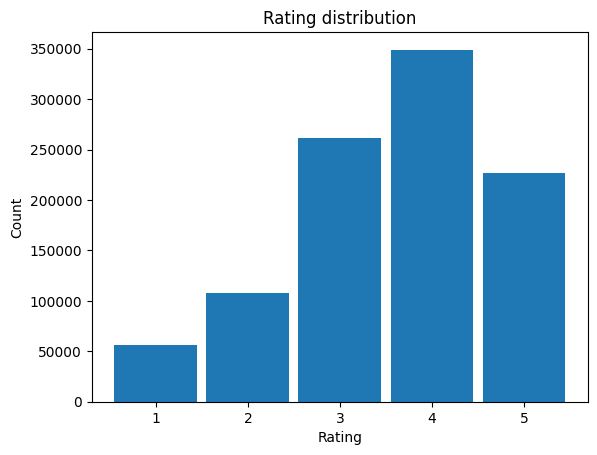

In [14]:
import matplotlib.pyplot as plt

# Rating distribution
ratings["rating"].plot(kind="hist", bins=[0.5,1.5,2.5,3.5,4.5,5.5], rwidth=0.9)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating distribution")
plt.show()

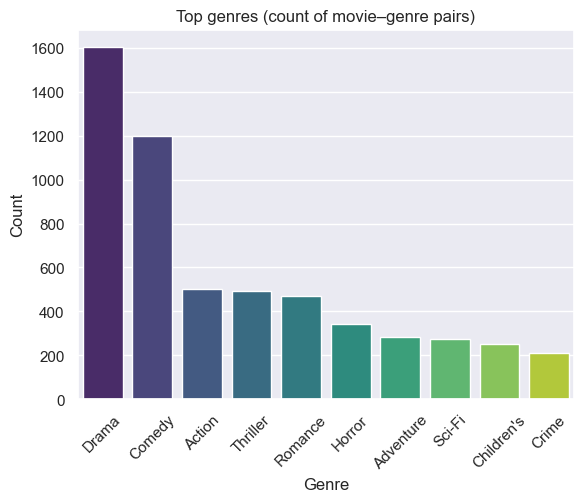

In [15]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# Top 10 genres
top_genres = movie_genres_long["genre"].value_counts().head(10).reset_index()
sns.barplot(data=top_genres, x="genre", y="count", hue="genre", palette="viridis")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Top genres (count of movie–genre pairs)")
plt.xticks(rotation=45)
plt.show()


### You’re done!

You created a cleaned, merged table ready for exploration or modeling.
If you saved the CSVs above, you can load them in another notebook or tool.
